<center>
   <img src="logounam.png"width="150">
</center>


  <font size="6"><b> <center> Universidad Nacional Autónoma de México     </b> <br> </font>
  <font size="4"><b> <center> Posgrado en Ciencias de la Tierra </b><br> </font>
  <font size="3"> <center> 1D CNN implementation for Seismic Event detection in Paricutin Data </b> <br> </font>
  <font size="3"><b> <center>@Author: MSc. Kevin Axel Vargas-Zamudio </b> <br> </font>
  <font size="3"><b> <center>email: seismo.ai.kevvargas@gmail.com </b><br></font>

# Observed data for 2022 Paricutin Seismic Swarm
## 1D CNN development for Local Seismic Event Detection
### Supervised dataset construction: output: X (CNN input) and Y (CNN target)
### Stage 1: Data cleaning 

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.io import loadmat,savemat
from scipy.signal import decimate
import scipy.io as scio

from os.path import dirname, join as pjoin
import matlab.engine
import sys
import copy as copy
import os
import time

In [83]:
# Initialization of matlab engine for signal retrieving 
import matlab.engine
names = matlab.engine.find_matlab()
#print(names)
engine_mat = matlab.engine.connect_matlab(names[0])

In [84]:
os.path.basename("/StorageCitlalli/Paricutin/EnjambreParicutin/Script_sismo_id_h2/res/")
os.path.basename("/StorageCitlalli/Paricutin/EnjambreParicutin/CNN1D/CNN1D_env/")
sys.path.append('/StorageCitlalli/Paricutin/EnjambreParicutin/Script_sismo_id_h2/res/')

In [85]:
def matfiles_retrieve(month,day):
    # Retrieving .mat files from /res directory for a single day
    path = sys.path[-1]

    mat_fname = []

    for i in range(0,24):
        #month_day = month + 
        if i <= 9:
            mat_fname.append(path + 'pick2022_'+ month + '_' + day +'_0' + str(i) + '.mat')
        else:
            mat_fname.append(path + 'pick2022_'+ month + '_' + day + '_' + str(i) + '.mat')

    # .mat file list for a complete day (each .mat data file for 1 of 24 hours)
    mat_files = []
    for i in range(len(mat_fname)):
        mat_files.append(loadmat(mat_fname[i]))
        
    # Keys for data day dictionary
    data_day = list()
    for s in range(len(mat_fname[:])):
        data_day.append(mat_fname[s][72:-4])
        #print(data_day[s])
        
    # Create a Dictionary that contains tp and ts variable length vectors for each hour
    # Sorted and repetitions removed

    TPTS_1day = {}
    hours = []
    for i in range(24):
        TP = mat_files[i]['tp'][0] ; TP = TP[~np.isnan(TP)] 
        TS = mat_files[i]['ts'][0] ; TS = TS[~np.isnan(TS)]
        TPTS_1day[data_day[i]+'_tp'] = np.unique(np.sort(TP))
        TPTS_1day[data_day[i]+'_ts'] = np.unique(np.sort(TS))

        if any(TPTS_1day[data_day[i]+'_tp']) == False or \
        any(TPTS_1day[data_day[i]+'_ts']) == False:          # Removing hours wihout events
            TPTS_1day.pop(data_day[i]+'_tp')
            TPTS_1day.pop(data_day[i]+'_ts')
    
    keys = list(TPTS_1day.keys()) #'2022_09_21_03_tp'
    
    for j in range(0,len(keys),2):
        hours.append(int(keys[j][11:13]))

    return data_day, TPTS_1day, hours

In [86]:
def visualize_TPTS(hours,TPTS_day):
    
    for h in hours:
        print(f'Hour tp: {h} ',TPTS_day[data_day[h] + '_tp'])
        print(f'Hour ts: {h} ',TPTS_day[data_day[h] + '_ts'])

In [87]:
# Data visual inspection: removing detections
def remove_complete_detection(TPTS_1day,data_day,hours):
    for h in hours:
        TPTS_1day.pop(data_day[h]+'_tp')
        TPTS_1day.pop(data_day[h]+'_ts')
        keys = list(TPTS_1day.keys())
    #print(keys)
    new_hours = [] 
    for i in range(0,len(keys),2):
        new_hours.append(int(keys[i][11:13]))
    
    return TPTS_1day, keys, new_hours

In [88]:
# Cleaning false detections or error detections
def remove_some_detections(TPTS_1day,data_day,hours,TP_index):    
    for h in hours:
        n = len(TP_index[data_day[h]])
        TPTS_1day[data_day[h]+'_tp'] = np.delete(TPTS_1day[data_day[h]+'_tp'],TP_index[data_day[h]],axis=0)
    
    keys = list(TPTS_1day.keys())
    index_array = []
    
    for i in range(0,len(keys),2):
        index_array.append(int(keys[i][11:13]))
    
    #print(index_array) # This is for retrieving NRG signal in certain hour  
    
    return TPTS_1day, index_array

In [89]:
def count_local_events(index_array,TPTS_day):
    # Counting how many events respect to tp parameter
    aux = 0
    count_event = 0
    for i in index_array:
        tp = TPTS_day[data_day[i]+ '_tp']
        aux = len(tp)
        count_event += aux
    return count_event

In [90]:
def time_windowing(Ndec,Nsamp_win,Nover,overlap):    
    # Time vector and window parameters
    time = np.arange(0,Ndec,1)
    t_end = time[-1]
    t_ini = time[0]

    Nwin = int(np.round((t_end/wind_time)))
    Nhours = len(index_array)
    Nwin_no_overlap = int(Ndec/Nsamp_win)
    Nwin_overlap = int(Nwin_no_overlap/overlap)
    # Windowing 1 signal and overlapping it 

    #print(t_ini,t_end,dt,len(time),Nsamp_w)
    print(f'Samples/window: {Nsamp_win} \t Num of windows without overlapping: {Nwin_no_overlap}')
    print(f'Samples Overlapped: {Nover} considering {overlap} of overlap')
    print(f'Num of windows with overlap: {Nwin_overlap}')
    print(f'Number of efective detection hours: {Nhours}')
    
    return time, Nhours

In [126]:
def retrieve_raw_signal(month,day,data_day,index_array):
    print(data_day,index_array)
    signal_raw = {}
    day_py   = matlab.double(int(day))
    
    # For interface this number must be between 1 and 6, that are the indices of an array specific for year 2022
    if month == '09':
        month_py = matlab.double(int(3)) # corresponds to september
    elif month == '10':
        month_py = matlab.double(int(4))
    elif month == '11':
        month_py = matlab.double(int(5))

    for h in index_array: # loop for selected hours
        if h == 0:
            signal_raw[data_day[h]+'_sig0'] = np.array(engine_mat.Interface_from_python(month_py,day_py,h+1))[0,500:359500,:]    
        else:
            print(h)
            signal_raw[data_day[h]+'_sig0'] = np.array(engine_mat.Interface_from_python(month_py,day_py,h))[0,500:359500,:]
    
    return signal_raw

In [92]:
def NRG_signal_decimated(signal_raw,N,k_samp,index_array):
    
    Nh = len(index_array)
    Ndec = int(N/k_samp)
    NRG = np.zeros((N,24))
    NRG_dec = np.zeros((Ndec,24))

    for i in (index_array):
        NRG[:,i] = signal_raw[data_day[i]+'_sig0'][:,3]
        NRG[:,i] /= np.max(NRG[:,i])
        NRG_dec[:,i] = decimate(NRG[:,i],k_samp)
    
    return NRG_dec, Ndec

In [93]:
def Xinput_figure(Nsamp_win,count_event,data_month,TPTS_day,NRG_dec,time,fsamp_local,Nover,index_array):
    # Interest windows for 1 hour signal

    wind_label = np.zeros((Nsamp_win,6))
    twin_label = np.zeros((Nsamp_win,6))

    mpl.rcParams['figure.figsize'] = [30,25]#[50,count_event]#[30,Nrec]
    fig,ax = plt.subplots(count_event,6)

    iplot = 0
    fig.suptitle(f'X input for {data_month}',fontsize=32)
    for i in index_array:
        tp = TPTS_day[data_day[i]+ '_tp']
        Ntp = len(tp)
        for k in range(Ntp):
            if (tp[k] >= 40 and tp[k] <= 3545.0):
                #wind_label[:,0] = NRG_dec[int(np.ceil(tp[k]*fsamp_local - 3*Nover)):int(np.ceil(tp[k]*fsamp_local - Nover)),i]
                #twin_label[:,0] = time[int(np.ceil(tp[k]*fsamp_local - 3*Nover)):int(np.ceil(tp[k]*fsamp_local - Nover))]

                wind_label[:,1] = NRG_dec[int(np.ceil(tp[k]*fsamp_local - 2*Nover)):int(np.ceil(tp[k]*fsamp_local)),i]
                twin_label[:,1] = time[int(np.ceil(tp[k]*fsamp_local - 2*Nover)):int(np.ceil(tp[k]*fsamp_local))]

                wind_label[:,2] = NRG_dec[int(np.ceil(tp[k]*fsamp_local - Nover)):int(np.ceil(tp[k]*fsamp_local + Nover)),i]
                twin_label[:,2] = time[int(np.ceil(tp[k]*fsamp_local - Nover)):int(np.ceil(tp[k]*fsamp_local + Nover))]

                wind_label[:,3] = NRG_dec[int(np.ceil(tp[k]*fsamp_local)):int(np.ceil(tp[k]*fsamp_local + 2 * Nover)),i]
                twin_label[:,3] = time[int(np.ceil(tp[k]*fsamp_local)):int(np.ceil(tp[k]*fsamp_local + 2 *  Nover))]

                wind_label[:,4] = NRG_dec[int(np.ceil(tp[k]*fsamp_local + Nover)):int(np.ceil(tp[k]*fsamp_local + 3*Nover)),i]
                twin_label[:,4] = time[int(np.ceil(tp[k]*fsamp_local + Nover)):int(np.ceil(tp[k]*fsamp_local + 3*Nover))]

                wind_label[:,5] = NRG_dec[int(np.ceil(tp[k]*fsamp_local + 2*Nover)):int(np.ceil(tp[k]*fsamp_local + 4*Nover)),i]
                twin_label[:,5] = time[int(np.ceil(tp[k]*fsamp_local + 2*Nover)):int(np.ceil(tp[k]*fsamp_local + 4*Nover))]

                for j in range(6): # Loop for windows
                    if j == 2 or j == 3 or j == 4:
                        color = 'magenta'
                    elif j == 1 or j == 5:
                        color = 'green'
                    else: 
                        color = 'blue'
                    ax[iplot,j].plot(twin_label[:,j],wind_label[:,j],color=color)

                    ax[iplot,j].tick_params(left = False, right = False , labelleft = True ,
                        labelbottom = True, bottom = False, labeltop = False)
                    if j == 0:
                        ax[iplot,j].set_ylabel(f'Hour: {i}',fontsize = 28)
                iplot += 1
            else:
                continue  

    plt.tight_layout(rect=[0, 0, 1, 0.95])        
    fig.savefig("X_input_figures/"+ data_month+".png", bbox_inches='tight', pad_inches=0,dpi=500)        


In [95]:
def X_input_Y_target(Nsamp_win,Nhours,count_event,index_array,TPTS_day,data_day,NRG_dec,fsamp_local,Nover,data_month):
    # X input window for one day
    # Making of X input CNN data
    t_window      = np.zeros((Nsamp_win))
    window        = np.zeros((Nsamp_win,Nhours))
    X_input       = np.zeros((6 * count_event,Nsamp_win))
    y_target      = np.zeros((6 * count_event))

    aux = 0
    for i in index_array:
        tp = TPTS_day[data_day[i]+ '_tp']
        Ntp = len(tp)
        for k in range(Ntp):
            #print('index_array,k,tp[k]: ',i,k,tp[k])
            if (tp[k] >= 45 and tp[k] <= 3545.0):
                #X_input[(aux*6) + 0 ,:] = NRG_dec[int(np.ceil(tp[k]*fsamp_local - 3*Nover)):int(np.ceil(tp[k]*fsamp_local - Nover)),i]
                #X_input[(aux*6) + 1 ,:] = NRG_dec[int(np.ceil(tp[k]*fsamp_local - 2*Nover)):int(np.ceil(tp[k]*fsamp_local)),i]
                X_input[(aux*6) + 2 ,:] = NRG_dec[int(np.ceil(tp[k]*fsamp_local - Nover)):int(np.ceil(tp[k]*fsamp_local + Nover)),i]
                X_input[(aux*6) + 3 ,:] = NRG_dec[int(np.ceil(tp[k]*fsamp_local)):int(np.ceil(tp[k]*fsamp_local + 2 * Nover)),i]
                X_input[(aux*6) + 4 ,:] = NRG_dec[int(np.ceil(tp[k]*fsamp_local + Nover)):int(np.ceil(tp[k]*fsamp_local + 3*Nover)),i]
                X_input[(aux*6) + 5 ,:] = NRG_dec[int(np.ceil(tp[k]*fsamp_local + 2*Nover)):int(np.ceil(tp[k]*fsamp_local + 4*Nover)),i]

                y_target[(aux*6) + 0] = 0
                y_target[(aux*6) + 1] = 1
                y_target[(aux*6) + 2] = 2
                y_target[(aux*6) + 3] = 2
                y_target[(aux*6) + 4] = 2
                y_target[(aux*6) + 5] = 1

                aux += 1
            else:
                continue

    # Saving .mat files with X inputs per day
    saveXY = {'Xinput':X_input,'Ytarget':y_target}
    savemat(f'X_input_mat/Xinput_{data_month}.mat',saveXY)

In [96]:
def month_day_str():
    month = []
    day1 = [] ; day2 = []

    for i in range(1,13):
        if i <= 9:
            month.append('0'+str(i))
        else:
            month.append(str(i))
    for i in range(1,31):
        if i <= 9:
            day1.append('0'+str(i))
        else:
            day1.append(str(i))
    day2 = copy.copy(day1)
    day2.append('31')
    
    return month, day1, day2

In [97]:
def retrieve_noise_hours(mat_files,day_noise):
    
    Noise_matfiles = []
    hours_noise = {}
    
    for j in range(len(mat_files)):
        Noise_matfiles.append(loadmat('X_input_mat/' + mat_files[j]))
        #Noise_02092022 = loadmat('X_input_mat/' + mat_files[1])
    
        keys = list(Noise_matfiles[j].keys())
        hours = []
        for i in range(3,len(keys),2):
            #print(keys[i][0:2])
            hours.append(int(keys[i][0:2]))
        
        hours_noise[day_noise[j]] = hours
            
    return hours_noise , Noise_matfiles


In [198]:
def noise_windowing(ini_fin,NRG_dec,hours_noise,dt,Nsamp_win,wind_time,fsamp,N_events):
    
    noise_window = np.zeros((N_events,Nsamp_win))
    
    aux = 0
    for i in hours_noise:
        print('hours_noise:',i)
        if i <= 9:
            ini = ini_fin['0'+str(i)+'_ini'][0]   # Variable length: it is possible to retrieve more than one noise interval 
            fin = ini_fin['0'+str(i)+'_fin'][0]
        else:
            ini = ini_fin[str(i)+'_ini'][0]
            fin = ini_fin[str(i)+'_fin'][0]
        
        print('len ini:',len(ini))
        Nwin_interval = np.zeros((len(ini)),dtype=int)
        
        for j in range(len(ini)):
            Nwin_interval[j] = int(((fin[j]-ini[j])*fsamp)/Nsamp_win)
            print(f'Nwin_interval {j}: {Nwin_interval[j]}')
            
            for k in range(Nwin_interval[j]):
                noise_window[aux,:] =  NRG_dec[int(ini[j]*fsamp) + (Nsamp_win*k) : int(ini[j]*fsamp) + (Nsamp_win*(k+1)) ,i]
        
                aux += 1        
                
                print('aux= ',aux)
    return noise_window
            

In [163]:
ini_fin
ini_fin.keys()
hours_noise

{'2022_09_01': [3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17],
 '2022_09_02': [1, 4, 5, 6, 8, 9, 10, 11, 13, 15]}

In [98]:
months , day_30, day_31 = month_day_str()
months[8:11]
day_30[0:5]

['01', '02', '03', '04', '05']

In [99]:
# Sampling and resampling parameters
fsamp_orig = 100 #[Hz]
fsamp_local = 20 #[Hz]
k_samp = int(fsamp_orig / fsamp_local)

# Overlapping window parameters
dt = 1/(100/k_samp)   # Fdr decimated signal to 50 Hz == time * 50
wind_time = 20   # s
Nsamp_win = int(wind_time/dt)              # Samples number in each window
overlap = 0.5
Nover = int(np.round((Nsamp_win*overlap)))

In [137]:
""" Main program"""
import time

# Loading 'Remove_hours' dictionary
Remove_hours = loadmat('X_input_mat/Remove_hours_091011.mat')

months , day_30, day_31 = month_day_str()
days = []
 
# testing stuff
#monthsss = ['09']
#daysssss = ['05']

count_total = 0

start_time = time.time()   # Timing process
for month in months[8:11]:#:#monthsss
    if  month == '01' or month == '03' or month == '05' or month == '07' \
    or month == '08' or month == '10' or month == '12':
        days = copy.copy(day_31)
    elif month == '04' or month == '06' or month == '09' or month == '11':
        days = copy.copy(day_30)
        
    for day in days:#[15:]:##daysssss
        data_day , TPTS_day, hours = matfiles_retrieve(month,day)
        
        #Removing complete hours with no useful data
        data_month = data_day[0][0:10]
        if Remove_hours[data_month].shape != (0,0) :
            TPTS_day, keys, index_array = remove_complete_detection(TPTS_day,data_day,Remove_hours[data_month][0])
        else:
            index_array = []
            keys = list(TPTS_day.keys())
            for i in range(0,len(keys),2):
                index_array.append(int(keys[i][11:13]))             

        #Remove selected events!
        # Cleaned Picking
        #TPTS_day,index_array = remove_some_detections(TPTS_day,data_day,index_hours,TP_index)
        #print('Index Array',index_array)]

        """Calling SeisPick program in order to retrieve specific hours with false detections
        Testing calls from here to Matlab seismicpick program interface through function
        Retrieving Raw Signal"""
        
        #signal_raw = retrieve_raw_signal(month,day,data_day,index_array)

        """ Structures for component retrieve: Signal energy + normalization + decimate """
        #if index_array[0] <= 9: 
        #    N = len(signal_raw[data_month + '_0' + str(index_array[0]) + '_sig0'])
        #else:
        #    N = len(signal_raw[data_month + '_' + str(index_array[0]) + '_sig0'])
            
        #NRG_dec, Ndec = NRG_signal_decimated(signal_raw,N,k_samp,index_array)
        #print(NRG_dec,Ndec)

        """ Time vector, efective number of signal hours and count of events """
        #time , Nhours = time_windowing(Ndec,Nsamp_win,Nover,overlap)
        #count_event = count_local_events(index_array,TPTS_day)
        #print(f'Count Events for {data_month}: {count_event} \n')
        
        # Counting total events from september to november!
        #count_total += count_event
        #print(f'-------------Total events to {data_month}: {count_total}------------------')

#         """ X input windows visualization """
#         opc = False #True
#         if opc:
#             Xinput_figure(Nsamp_win,count_event,data_month,TPTS_day,NRG_dec,time,fsamp_local,Nover,index_array)

#         """ X input and Y target saving into .mat structures """
#         X_input_Y_target(Nsamp_win,Nhours,count_event,index_array,TPTS_day,data_day,NRG_dec,fsamp_local,Nover,data_month)

print("---X input, y target Process execution time: %s seconds ---" % (time.time() - start_time))

---X input, y target Process execution time: 0.9112682342529297 seconds ---


In [140]:
data_day[23]

'2022_11_30_23'

In [121]:
hours_noise

{'2022_09_01': [3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17],
 '2022_09_02': [1, 4, 5, 6, 8, 9, 10, 11, 13, 15]}

In [80]:
hours_noise['2022_'+month+'_'+day]

[1, 4, 5, 6, 8, 9, 10, 11, 13, 15]

In [108]:
list(hours_noise.keys())

['2022_09_01', '2022_09_02']

In [213]:
Noise_intervals[0]

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu Mar  2 13:00:27 2023',
 '__version__': '1.0',
 '__globals__': [],
 '03_ini': array([[100]]),
 '03_fin': array([[1100]]),
 '04_ini': array([[600]]),
 '04_fin': array([[1600]]),
 '05_ini': array([[500]]),
 '05_fin': array([[3000]]),
 '07_ini': array([[200]]),
 '07_fin': array([[1200]]),
 '08_ini': array([[50]]),
 '08_fin': array([[750]]),
 '09_ini': array([[50]]),
 '09_fin': array([[3050]]),
 '10_ini': array([[50]]),
 '10_fin': array([[2550]]),
 '11_ini': array([[600]]),
 '11_fin': array([[2600]]),
 '12_ini': array([[800]]),
 '12_fin': array([[2800]]),
 '14_ini': array([[ 600, 3000]]),
 '14_fin': array([[1000, 3400]]),
 '15_ini': array([[800]]),
 '15_fin': array([[2000]]),
 '17_ini': array([[100]]),
 '17_fin': array([[1800]])}

In [158]:
Noise_intervals[1]['04_ini']

array([[500]])

In [152]:
index_array[0]
data_month

'2022_11_30'

In [199]:
""" Testing program for noise windows retrieval separated from main program
     Include this chunk of code within the main loop in signal retrieval
     """

mat_files = ['Noise_Intervals_01092022.mat','Noise_Intervals_02092022.mat']
day_noise = ['2022_09_01','2022_09_02']

hours_noise , Noise_intervals = retrieve_noise_hours(mat_files,day_noise)
months = ['09']

for i in range(len(list(hours_noise.keys()))):
    print(i)
    #data_day

for month in months:
    if month == '09':
        days = ['01','02']
    
    for day in days:
        print(month,day)
        data_day , TPTS_day, hours = matfiles_retrieve(month,day)
        
        print(len(data_day),len(hours_noise['2022_'+month+'_'+day]))
        
#       Retrieve complete NRG signal for noise recovery
        data_month = data_day[0][0:10]
        signal_for_noise = retrieve_raw_signal(month,day,data_day,hours_noise['2022_'+month+'_'+day])
        
        if hours_noise['2022_'+month+'_'+day][0] <= 9: 
            N = len(signal_for_noise[data_month + '_0' + str(hours_noise['2022_'+month+'_'+day][0]) + '_sig0'])
        else:
            N = len(signal_for_noise[data_month + '_' + str(hours_noise['2022_'+month+'_'+day][0]) + '_sig0'])
            
        NRG_dec, Ndec = NRG_signal_decimated(signal_for_noise,N,k_samp,hours_noise['2022_'+month+'_'+day])
        #print(NRG_dec,Ndec)
        
        """ Time vector, efective number of signal hours and count of events """
        time , Nhours = time_windowing(Ndec,Nsamp_win,Nover,overlap)
        print(NRG_dec.shape)
        #plt.plot(time,NRG_dec)
        
        if month == '09' and day == '01':
            ini_fin = Noise_intervals[0]#['03_ini']
        elif month == '09' and day == '02':
            ini_fin = Noise_intervals[1]
        
        Nevents = 2015
        noise = noise_windowing(ini_fin,NRG_dec,hours_noise['2022_'+month+'_'+day],
                        dt,Nsamp_win,wind_time,fsamp_local,Nevents)


0
1
09 01
24 12
['2022_09_01_00', '2022_09_01_01', '2022_09_01_02', '2022_09_01_03', '2022_09_01_04', '2022_09_01_05', '2022_09_01_06', '2022_09_01_07', '2022_09_01_08', '2022_09_01_09', '2022_09_01_10', '2022_09_01_11', '2022_09_01_12', '2022_09_01_13', '2022_09_01_14', '2022_09_01_15', '2022_09_01_16', '2022_09_01_17', '2022_09_01_18', '2022_09_01_19', '2022_09_01_20', '2022_09_01_21', '2022_09_01_22', '2022_09_01_23'] [3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17]
3
> In prepare_sig2_py (line 9)
In compute_py (line 122)
In Interface_from_python (line 411)
> In compute_py (line 196)
In Interface_from_python (line 411)
4
> In prepare_sig2_py (line 9)
In compute_py (line 122)
In Interface_from_python (line 411)
> In compute_py (line 196)
In Interface_from_python (line 411)
5
> In prepare_sig2_py (line 9)
In compute_py (line 122)
In Interface_from_python (line 411)
> In compute_py (line 196)
In Interface_from_python (line 411)
7
> In prepare_sig2_py (line 9)
In compute_py (line 122)
In Inte

In [200]:
noise.shape

(2015, 400)

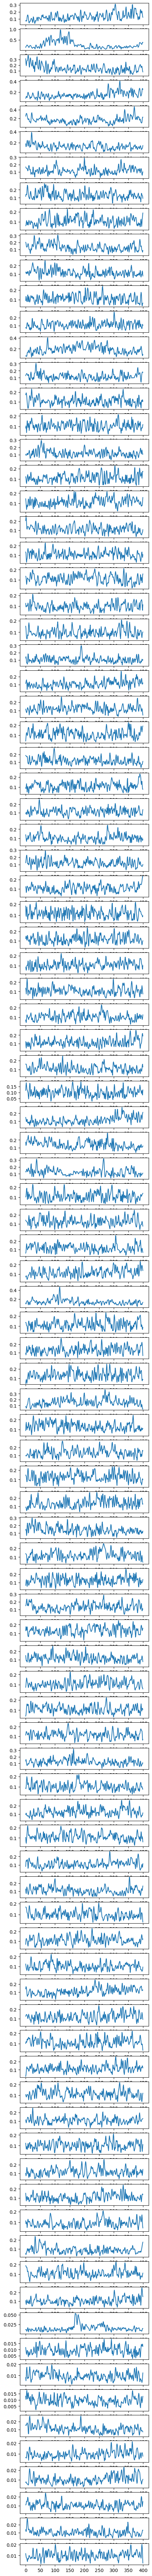

In [226]:
mpl.rcParams['figure.figsize'] = [5,100]
fig,ax = plt.subplots(100,1)
for i in range(100):
    ax[i].plot(noise[i,:])
    #ax[i].set_ylim(0,1)

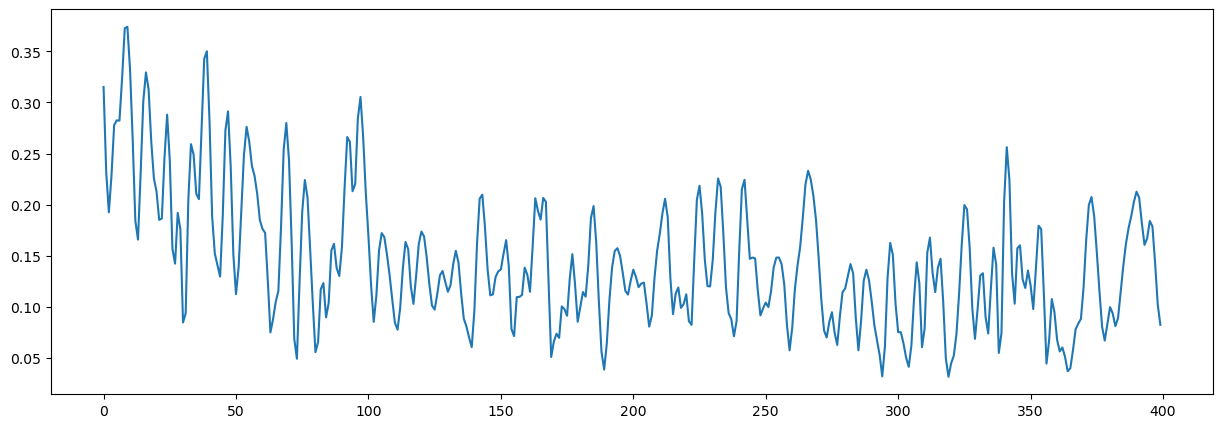

In [215]:
fig = plt.figure(figsize = [15,5])
plt.plot(noise[2,:])

In [192]:
Noise_intervals[0]

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu Mar  2 13:00:27 2023',
 '__version__': '1.0',
 '__globals__': [],
 '03_ini': array([[100]]),
 '03_fin': array([[1100]]),
 '04_ini': array([[600]]),
 '04_fin': array([[1600]]),
 '05_ini': array([[500]]),
 '05_fin': array([[3000]]),
 '07_ini': array([[200]]),
 '07_fin': array([[1200]]),
 '08_ini': array([[50]]),
 '08_fin': array([[750]]),
 '09_ini': array([[50]]),
 '09_fin': array([[3050]]),
 '10_ini': array([[50]]),
 '10_fin': array([[2550]]),
 '11_ini': array([[600]]),
 '11_fin': array([[2600]]),
 '12_ini': array([[800]]),
 '12_fin': array([[2800]]),
 '14_ini': array([[ 600, 3000]]),
 '14_fin': array([[1000, 3400]]),
 '15_ini': array([[800]]),
 '15_fin': array([[2000]]),
 '17_ini': array([[100]]),
 '17_fin': array([[1800]])}

In [190]:
ini_fin = Noise_intervals[0]
ini_fin['03_ini'][0][0]

100

In [146]:
signal_for_noise['2022_09_02_01_sig0'].shape

(359000, 4)

In [179]:
# import time
# start_time = time.time()

# # for i in range(100):
# #     print(i)

# print("---X input, y target Process execution time: %s seconds ---" % (time.time() - start_time))

In [177]:
#signal_raw

In [188]:
NRG_dec.shape

(71800, 24)

In [178]:
# plt.figure(figsize=(10,3))
# plt.plot(NRG_dec[:,19])

In [180]:
x = 1
type(type(x))
'int' == type(x)
type(int)
[] == (~False)
[] == (True)
bool(~([] == (True)))
#Remove_hours = loadmat('X_input_mat/Remove_hours_091011.mat')

#Remove_hours

#array([], shape=(0, 0), dtype=float64),
Remove_hours['2022_10_21'].shape
Remove_hours['2022_10_22'].shape

(1, 3)